#資料預處理

####整合106-109年不動產買賣交易紀錄（含預售屋）

In [130]:
import numpy as np

In [131]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [132]:
import glob
import pandas as pd
os.chdir("/content/drive/MyDrive/Colab Notebooks/資料探勘final/")
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
#combine all files in the list
df = pd.concat([pd.read_csv(f,encoding='utf-8') for f in all_filenames ])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


####了解原始資料全貌

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189522 entries, 0 to 5737
Data columns (total 28 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   鄉鎮市區           189506 non-null  object 
 1   交易標的           189522 non-null  object 
 2   土地區段位置-建物區段門牌  189201 non-null  object 
 3   土地移轉總面積-平方公尺   189522 non-null  float64
 4   都市土地使用分區       168177 non-null  object 
 5   非都市土地使用分區      18377 non-null   object 
 6   非都市土地使用編定      18366 non-null   object 
 7   交易年月           189522 non-null  int64  
 8   移轉層次           150395 non-null  object 
 9   總樓層數           150293 non-null  object 
 10  建物型態           189522 non-null  object 
 11  主要用途           150261 non-null  object 
 12  主要建材           150331 non-null  object 
 13  建築完成年月         141350 non-null  object 
 14  屋齡             189522 non-null  int64  
 15  建物移轉總面積-平方公尺   189522 non-null  float64
 16  建物現況格局-房       189522 non-null  int64  
 17  建物現況格局-廳       189522 non-null 

In [134]:
df.head()

,鄉鎮市區,交易標的,土地區段位置-建物區段門牌,土地移轉總面積-平方公尺,都市土地使用分區,非都市土地使用分區,非都市土地使用編定,交易年月,移轉層次,總樓層數,建物型態,主要用途,主要建材,建築完成年月,屋齡,建物移轉總面積-平方公尺,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,建物現況格局-隔間,有無管理組織,總價-元,單價-每平方公尺,車位類別,車位移轉總面積-平方公尺,車位總價-元,備註,地所狀態
0,中區,房地(土地+建物),臺中市中區綠川西街115之1~30號,0.00,商,NaN,NaN,10608,三層,十層,其他,見其他登記事項,見其他登記事項,660215,41,0.01,0,0,0,無,有,146,0.0,NaN,0.0,0,NaN,2(資料揭露)
1,中區,房地(土地+建物),臺中市中區綠川西街115之1~30號,0.00,商,NaN,NaN,10608,三層,十層,其他,見其他登記事項,見其他登記事項,660215,41,0.01,0,0,0,無,有,146,0.0,NaN,0.0,0,NaN,2(資料揭露)
2,中區,車位,臺中市中區三民路二段121~150號,0.59,商,NaN,NaN,10611,NaN,NaN,其他,NaN,NaN,NaN,0,9.94,0,0,0,有,無,30000,NaN,升降機械,0.0,30000,單獨車位交易。,2(資料揭露)
3,中區,房地(土地+建物),臺中市中區中華路一段121~150號,1.65,商,NaN,NaN,10609,地下一層,十九層,其他,見其他登記事項,鋼骨鋼筋混凝土造,850520,21,202.44,0,0,0,無,有,200000,988.0,NaN,0.0,0,NaN,2(資料揭露)
4,中區,建物,臺中市中區綠川西街121~150號,0.00,NaN,NaN,NaN,10604,地下一層,十二層,其他,商業用,鋼筋混凝土造,791128,26,23.43,0,0,0,無,有,93000,3969.0,NaN,0.0,0,"親友、員工或其他特殊關係間之交易。\n本件建物係攤位,土地所有權人為財團法人臺灣省私立臺中仁愛之家",5(揭露且明細顯示備註)


In [135]:
df.describe()

,土地移轉總面積-平方公尺,交易年月,屋齡,建物移轉總面積-平方公尺,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,總價-元,單價-每平方公尺,車位移轉總面積-平方公尺,車位總價-元
count,189522.000000,189522.000000,189522.000000,189522.000000,189522.000000,189522.000000,189522.000000,1.895220e+05,1.866980e+05,189522.000000,1.895220e+05
mean,210.142229,10721.559829,10.736426,133.296324,2.425465,1.417830,1.724792,1.335001e+07,6.163185e+04,12.058268,3.735968e+05
std,1855.367614,145.469781,13.897045,324.789934,2.237262,1.114526,1.975699,5.799266e+07,5.056817e+04,21.794775,7.871853e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,15.990000,10609.000000,0.000000,45.170000,1.000000,0.000000,1.000000,4.460000e+06,4.154800e+04,0.000000,0.000000e+00
50%,26.560000,10709.000000,1.000000,125.870000,3.000000,2.000000,2.000000,7.820000e+06,5.632700e+04,0.000000,0.000000e+00
75%,85.390000,10809.000000,23.000000,174.527500,3.000000,2.000000,2.000000,1.230000e+07,7.515175e+04,26.340000,5.500000e+05
max,444158.000000,19002.000000,104.000000,82699.380000,132.000000,152.000000,96.000000,8.375890e+09,8.203988e+06,2989.000000,3.920000e+07


####刪除不必要欄位

1. 總樓層數：因爲建物型態有依照樓層高度不同做分類
2. 非都市土地使用分區、非都市土地使用編定：本身資料量過少（僅一萬多筆）
3. 主要用途與建材：因為missing value數量過多，此欄位為類別資料，無法補缺失
4. 總價：因為總價是單價乘以坪數，我們以每坪單價作為應變數
5. 鄉鎮市區：可從地址分佈上了解此資訊（描述性分析可以呈現）

In [136]:
df_new = df.drop(['鄉鎮市區','建築完成年月', '地所狀態','非都市土地使用分區','非都市土地使用編定','總樓層數', '主要用途','主要建材','總價-元'], axis=1)

####為資料建立新欄位：index


In [137]:
df_new = df_new.reset_index()
print(df_new.index)

RangeIndex(start=0, stop=189522, step=1)


####轉換數字to 日期（交易年月和完成年月）


In [138]:
df_new['交易年月'] = df_new['交易年月'].astype('int')

In [139]:
df_new['交易年月'] = df_new['交易年月']//100 


####刪除備註欄有文字(資訊揭露)的資料：因資訊揭露多半是公司、親友間交易

In [140]:
delete_index = []
for i, value in enumerate(df_new.備註):
  if type(value) != float:
    delete_index.append(i)
df_new = df_new.drop(delete_index)

In [141]:
df_new = df_new.drop(['備註'], axis = 1) #因為備註欄本身沒有資訊

####刪除標的為土地的資料，以及建物型態應該只保留「華廈」「公寓」「透天厝」「住宅大樓」

In [142]:
df_new = df_new.drop(df_new[df_new.交易標的 == '土地'].index)
df_new = df_new.drop(df_new[df_new.建物型態 == '其他'].index)
df_new = df_new.drop(df_new[df_new.建物型態 == '套房(1房1廳1衛)'].index)
df_new = df_new.drop(df_new[df_new.建物型態 == '辦公商業大樓'].index)
df_new = df_new.drop(df_new[df_new.建物型態 == '店面(店鋪)'].index)
df_new = df_new.drop(df_new[df_new.建物型態 == '廠辦'].index)
df_new = df_new.drop(df_new[df_new.建物型態 == '工廠'].index)
df_new = df_new.drop(df_new[df_new.建物型態 == '農舍'].index)
df_new = df_new.drop(df_new[df_new.建物型態 == '倉庫'].index)

In [143]:
df_new.建物型態.unique()

array(['華廈(10層含以下有電梯)', '住宅大樓(11層含以上有電梯)', '公寓(5樓含以下無電梯)', '透天厝'],
      dtype=object)

####如果移轉層次是4尾數，那就設為1，其餘設為0

In [144]:
df_new['移轉層次'] = df_new['移轉層次'].fillna('無')

In [145]:
df_new['移轉層次'] = df_new['移轉層次'].replace(to_replace=r'四層', value='1', regex=True)

In [146]:
df_new['移轉層次'] = df_new['移轉層次'].replace(to_replace=r'十四層', value='1', regex=True)

In [147]:
df_new['移轉層次'] = df_new['移轉層次'].replace(to_replace=r'二十四層', value='1', regex=True)

In [148]:
df_new['移轉層次'] = df_new['移轉層次'].replace(to_replace=r'\D', value='0', regex=True)

In [149]:
df_new['移轉層次'].unique()

array(['00', '00000', '1', '0', '000', '00000000', '0000', '01',
       '000000000', '000000', '000000000000000', '0000000', '00000000000',
       '000001', '000000000000', '001', '0000000000', '010000',
       '00000000010000000000000000', '0000000000000', '0000000001000',
       '0001', '0100000000', '0000001', '1000', '0000000000000000',
       '0000000100000', '00000001', '1000000', '00000000000000',
       '00010000000000000', '000000000100000000000', '000000000100000000',
       '00000000010000000', '00000000010000000000', '00100000',
       '0000000000000000000', '0000000001', '000000000000000000000000',
       '0001000', '01000', '000000000000000000000', '000000000000000000',
       '0000000001000000', '10000', '000000100000000000', '0000001000',
       '000000000100000', '00010000', '1000000000', '0000000001000000000',
       '000000000100000000000000000'], dtype=object)

In [150]:
new = []
for i in df_new['移轉層次']:
   if '1' in i:
     new.append(1)
   else:
     new.append(0) 
df_new['移轉層次'] = new

In [151]:
df_new.head()

,index,交易標的,土地區段位置-建物區段門牌,土地移轉總面積-平方公尺,都市土地使用分區,交易年月,移轉層次,建物型態,屋齡,建物移轉總面積-平方公尺,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,建物現況格局-隔間,有無管理組織,單價-每平方公尺,車位類別,車位移轉總面積-平方公尺,車位總價-元
6,6,房地(土地+建物),臺中市中區中華路一段171之1~30號,5.98,商,106,0,華廈(10層含以下有電梯),44,54.40,0,0,0,無,無,11029.0,NaN,0.0,0
8,8,房地(土地+建物),臺中市中區公園路31~60號,3.32,商,106,0,住宅大樓(11層含以上有電梯),35,25.59,1,1,1,有,有,11723.0,NaN,0.0,0
12,12,建物,臺中市中區光復路合作大樓1~30號,0.00,NaN,106,0,華廈(10層含以下有電梯),48,43.60,2,1,1,有,無,12500.0,NaN,0.0,0
17,17,建物,臺中市中區光復路合作大樓1~30號,0.00,NaN,106,0,華廈(10層含以下有電梯),48,43.60,2,1,1,有,無,13303.0,NaN,0.0,0
18,18,房地(土地+建物),臺中市中區中華路一段171之1~30號,8.38,商,106,1,華廈(10層含以下有電梯),45,73.81,3,1,1,有,有,13548.0,NaN,0.0,0


####Label Encoder ： 隔間和有無管理組織的index（有、無）轉成1, 0

In [152]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['無', '有'])
df_new['建物現況格局-隔間'] = le.transform(df_new['建物現況格局-隔間'])
df_new['有無管理組織'] = le.transform(df_new['有無管理組織'])

####修正車位類別：轉成平面跟機械

In [153]:
df_new['車位類別'] = df_new['車位類別'].fillna('無')

In [154]:
df_new['車位類別'].unique()

array(['無', '坡道平面', '坡道機械', '升降機械', '升降平面', '其他', '一樓平面', '塔式車位'],
      dtype=object)

In [155]:
df_new['車位類別'] = df_new['車位類別'].replace(to_replace=r'坡道平面', value='平面', regex=True)
df_new['車位類別'] = df_new['車位類別'].replace(to_replace=r'升降平面', value='平面', regex=True)
df_new['車位類別'] = df_new['車位類別'].replace(to_replace=r'一樓平面', value='平面', regex=True)
df_new['車位類別'] = df_new['車位類別'].replace(to_replace=r'坡道機械', value='機械', regex=True)
df_new['車位類別'] = df_new['車位類別'].replace(to_replace=r'升降機械', value='機械', regex=True)
df_new['車位類別'] = df_new['車位類別'].replace(to_replace=r'塔式車位', value='機械', regex=True)

In [156]:
df_new['車位類別'].unique()

array(['無', '平面', '機械', '其他'], dtype=object)

####土地使用分區保留商、住（根據論文），刪除兩萬多筆（可以再想一下）

In [157]:
df_new['都市土地使用分區'] = df_new['都市土地使用分區'].fillna('無')

In [158]:
df_new['都市土地使用分區'].unique()

array(['商', '無', '住', '其他', '農', '工'], dtype=object)

In [159]:
df_new = df_new.drop(df_new[df_new.都市土地使用分區 == '無'].index)
df_new = df_new.drop(df_new[df_new.都市土地使用分區 == '其他'].index)
df_new = df_new.drop(df_new[df_new.都市土地使用分區 == '農'].index)
df_new = df_new.drop(df_new[df_new.都市土地使用分區 == '工'].index)

####確認遺漏值

In [160]:
df_new.isnull().sum()

index            0
交易標的             0
土地區段位置-建物區段門牌    0
土地移轉總面積-平方公尺     0
都市土地使用分區         0
交易年月             0
移轉層次             0
建物型態             0
屋齡               0
建物移轉總面積-平方公尺     0
建物現況格局-房         0
建物現況格局-廳         0
建物現況格局-衛         0
建物現況格局-隔間        0
有無管理組織           0
單價-每平方公尺         0
車位類別             0
車位移轉總面積-平方公尺     0
車位總價-元           0
dtype: int64

####交易標的、都市土地使用分區轉label encoder

In [161]:
df_new.交易標的.unique()

array(['房地(土地+建物)', '房地(土地+建物)+車位'], dtype=object)

原本交易標的欄位有土地、房地（兩種）、車位、建物，但經過預處理後僅剩兩種資料，所以改用label encoder

In [162]:
le = preprocessing.LabelEncoder()
le.fit(['房地(土地+建物)', '房地(土地+建物)+車位'])
df_new['交易標的'] = le.transform(df_new['交易標的'])
le.fit(['商', '住'])
df_new['都市土地使用分區'] = le.transform(df_new['都市土地使用分區'])


####建物型態、車位類別轉成one hot encoder

In [163]:
df_new = df_new.join(pd.get_dummies(df_new.建物型態))
df_new = df_new.join(pd.get_dummies(df_new.車位類別))

In [164]:
df_new = df_new.drop(['建物型態','車位類別'], axis = 1)

In [165]:
df_new

,index,交易標的,土地區段位置-建物區段門牌,土地移轉總面積-平方公尺,都市土地使用分區,交易年月,移轉層次,屋齡,建物移轉總面積-平方公尺,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,建物現況格局-隔間,有無管理組織,單價-每平方公尺,車位移轉總面積-平方公尺,車位總價-元,住宅大樓(11層含以上有電梯),公寓(5樓含以下無電梯),華廈(10層含以下有電梯),透天厝,其他,平面,機械,無
6,6,0,臺中市中區中華路一段171之1~30號,5.98,1,106,0,44,54.40,0,0,0,1,1,11029.0,0.00,0,0,0,1,0,0,0,0,1
8,8,0,臺中市中區公園路31~60號,3.32,1,106,0,35,25.59,1,1,1,0,0,11723.0,0.00,0,1,0,0,0,0,0,0,1
18,18,0,臺中市中區中華路一段171之1~30號,8.38,1,106,1,45,73.81,3,1,1,0,0,13548.0,0.00,0,0,0,1,0,0,0,0,1
27,27,0,臺中市中區光復路合作大樓1~30號,12.75,1,106,0,0,62.16,2,1,1,0,1,16892.0,0.00,0,0,0,1,0,0,0,0,1
46,46,0,臺中市中區成功路331~360號,7.00,0,106,0,39,49.73,2,1,1,0,1,20913.0,0.00,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189402,5618,1,大義段31~60地號,18.24,0,108,0,0,126.26,2,2,1,0,1,61919.0,28.39,960000,1,0,0,0,0,1,0,0
189406,5622,1,大義段31~60地號,33.32,0,108,0,0,223.56,3,2,2,0,1,63497.0,56.78,1920000,1,0,0,0,0,1,0,0
189408,5624,1,大義段31~60地號,24.59,0,108,0,0,251.95,3,2,2,0,1,63976.0,85.17,3210000,1,0,0,0,0,1,0,0
189442,5658,1,福大段121~150地號,24.84,0,108,0,0,112.71,3,2,2,0,1,82208.0,29.75,1050000,0,0,1,0,0,1,0,0


#描述性統計

####先了解單價分佈（平均單價、標準差、中位數）=>方便把數值資料轉成類別資料


####自變數欄位資料分布

In [ ]:
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
!mv taipei_sans_tc_beta.ttf  /usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf

from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt 

# 自定義字體變數
myfont = FontProperties(fname=r'/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/taipei_sans_tc_beta.ttf')


--2021-06-02 07:20:48--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 216.58.192.78, 2607:f8b0:4026:802::200e
Connecting to drive.google.com (drive.google.com)|216.58.192.78|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/sg4uvdn4mojna2s0k8pul275dhjnl7sc/1622618400000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2021-06-02 07:20:49--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/sg4uvdn4mojna2s0k8pul275dhjnl7sc/1622618400000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 216.58.192.65, 2607:f8b0:4026:802::2001
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|216.58.192.65|:443

In [ ]:
# import matplotlib.pyplot as plt
# plt.bar(df_new['鄉鎮市區'].unique(),
#         df_new['鄉鎮市區'].value_counts(), 
#         width=0.5, 
#         bottom=None, 
#         align='center', 
#         color=['lightsteelblue', 
#                'cornflowerblue', 
#                'royalblue', 
#                'midnightblue', 
#                'navy', 
#                'darkblue', 
#                'mediumblue'],
#         )
# plt.xticks(rotation='vertical', fontproperties=myfont)
# plt.show()

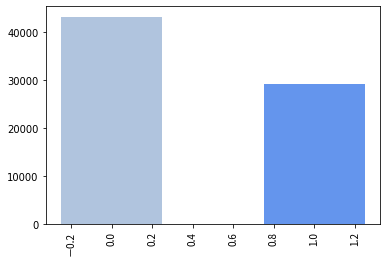

In [ ]:
import matplotlib.pyplot as plt
plt.bar(df_new['交易標的'].unique(),
        df_new['交易標的'].value_counts(), 
        width=0.5, 
        bottom=None, 
        align='center', 
        color=['lightsteelblue', 
               'cornflowerblue', 
               'royalblue', 
               'midnightblue', 
               'navy', 
               'darkblue', 
               'mediumblue'],
        )
plt.xticks(rotation='vertical', fontproperties=myfont)
plt.show()

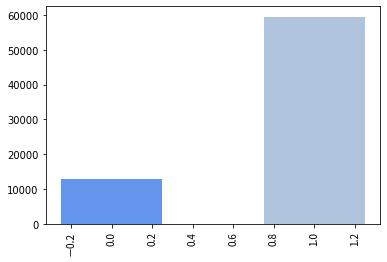

In [ ]:
import matplotlib.pyplot as plt
plt.bar(df_new['都市土地使用分區'].unique(),
        df_new['都市土地使用分區'].value_counts(), 
        width=0.5, 
        bottom=None, 
        align='center', 
        color=['lightsteelblue', 
               'cornflowerblue', 
               'royalblue', 
               'midnightblue', 
               'navy', 
               'darkblue', 
               'mediumblue'],
        )
plt.xticks(rotation='vertical', fontproperties=myfont)
plt.show()

####買賣交易分布（地圖形式）、平均單價走勢(折線圖)、交易年月（長條圖）、屋齡分佈（散佈圖）、土地使用分區（長條圖）

#####買賣交易分布（地圖形式)

In [ ]:
# 買賣交易分布（地圖形式）
import folium
import pandas as pd

# define the world map
# world_map = folium.Map()
# # display world map
# world_map

# Taichung latitude and longitude values
latitude = 24.2
longitude = 120.78
# Create map and display it
tc_map = folium.Map(location=[latitude, longitude], zoom_start=10)
# Display the map of Taichung
tc_map

import json
import requests
county_path = os.path.join(os.getcwd(),'data', 
                           '/content/drive/MyDrive/Colab Notebooks/資料探勘final/100年全國鄉鎮市區界圖.geojson') 
county_geojson = json.load(open(county_path))

folium.GeoJson(
    county_geojson,
    name='geojson'
    # style_function=lambda feature: {
    #     'fillColor': '#ffff00',
    #     'color': 'black',
    #     'weight': 2,
    #     'dashArray': '5, 5'
    # }
).add_to(tc_map)
folium.LayerControl().add_to(tc_map)
# tc_map.save("./mymap.html")
#display map
tc_map


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-41-0bfa163e172f>", line 20, in <module>
    county_path = os.path.join(os.getcwd(),'data',
FileNotFoundError: [Errno 2] No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'FileNotFoundError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/

FileNotFoundError: ignored

In [ ]:
# district = pd.DataFrame(df_new,columns=['土地區段位置-建物區段門牌'])
# district = district.reset_index(drop=True)
district = [['中區',0],['東區',0],['南區',0],['西區',0],['北區',0],['北屯區',0],['西屯區',0],['南屯區',0],
            ['太平區',0], ['大里區',0],['霧峰區',0],['烏日區',0],['豐原區',0],['后里區',0],['石岡區',0],
            ['東勢區',0],['新社區',0],['潭子區',0],['大雅區',0], ['神岡區',0],['和平區',0],
            ['大肚區',0],['沙鹿區',0],['龍井區',0],['梧棲區',0],['清水區',0],['大甲區',0],['外埔區',0],['大安區',0]]

for i in df_new['土地區段位置-建物區段門牌']:
  # print(i)
  for j in district:
    # print(j[0])
    if i.find(j[0]) != -1:
      j[1] +=1
# count
# print(district[2])
geo_count = pd.DataFrame(district, columns=['District', 'count'])
geo_count

In [ ]:
folium.Choropleth(
    geo_data=county_geojson,
    data=geo_count,
    columns=['District','count'],
    key_on='feature.properties.TOWN',
    fill_color='YlOrRd',
    fill_opacity=0.8,
    line_opacity=0.2,
    highlight=True,
    legend_name='House Trasaction',
).add_to(tc_map)
tc_map


In [ ]:
tc_map.save("./mymap.html")

#####交易年月（長條圖）

In [ ]:
#交易年月（長條圖）
years= df_new['交易年月'].reset_index(drop=True)
plt.bar(years.unique(),
        years.value_counts(), 
        width=0.5, 
        bottom=None, 
        align='center', 
        color=['lightsteelblue', 
               'cornflowerblue', 
               'royalblue', 
               'midnightblue', 
               'navy', 
               'darkblue', 
               'mediumblue'])
plt.title('交易年月', fontproperties=myfont)
plt.xticks(rotation=0, fontproperties=myfont)
plt.show()

In [ ]:
data = pd.DataFrame(df_new,columns=['交易年月','單價-每平方公尺'])
data = data.reset_index(drop=True)
# data
# print(df.groupby(by=['交易年月','單價-每平方公尺']).sum().groupby(level=[0]).cumsum())
groups = data.groupby(['交易年月'])['單價-每平方公尺'].agg('mean')
groups

In [ ]:
df_new['交易年月'] = df_new['交易年月'].replace(to_replace=190, value= 109, regex=True)
df_new = df_new.drop(df_new[df_new.交易年月 < 106].index)
# for i in df_new['交易年月']:
#   if i < 106:
#     df_new = df_new.drop(df_new[df_new.交易年月 == i].index)

In [ ]:
data = pd.DataFrame(df_new,columns=['交易年月','單價-每平方公尺'])
data = data.reset_index(drop=True)

groups = data.groupby(['交易年月'])['單價-每平方公尺'].agg('mean')
groups

In [ ]:
# groups = groups[7:-1]
# groups

#####平均單價走勢(折線圖)

In [ ]:
#平均單價走勢(折線圖)
# years = [100,101,102,103,104,105,106,107,108,109]
years = [106,107,108,109]
plt.plot(years, groups.iloc[:], color='b')
# plt.xlabel('交易年月') # 設定x軸標題
plt.xticks(years, rotation=0) # 設定x軸label以及垂直顯示
plt.title('年度平均單價走勢',fontproperties=myfont) # 設定圖表標題
plt.show()


#####屋齡分佈（散佈圖）

In [ ]:
#屋齡分佈（散佈圖）
# house_years= df_new['屋齡'].reset_index(drop=True)
plt.scatter(df_new['屋齡'], df_new['單價-每平方公尺'], alpha = 0.2)
plt.xlabel('屋齡',fontproperties=myfont)
plt.ylabel('單價-每平方公尺',fontproperties=myfont)
plt.show()

In [ ]:
priceQ = df_new['單價-每平方公尺'].quantile([0.25, 0.5, 0.75])
print(priceQ)

houseQ = df_new['屋齡'].quantile([0.25, 0.5, 0.75])
print(houseQ)

In [ ]:
#刪除 單價-每平方公尺 離群值
#IQR = Q3-Q1
IQR = np.percentile(df_new['單價-每平方公尺'],75) - np.percentile(df_new['單價-每平方公尺'],25)
#outlier = Q3 + 1.5*IQR 
df_new=df_new[df_new['單價-每平方公尺'] < np.percentile(df_new['單價-每平方公尺'],75)+1.5*IQR]
#outlier = Q1 - 1.5*IQR 
df_new=df_new[df_new['單價-每平方公尺'] > np.percentile(df_new['單價-每平方公尺'],25)-1.5*IQR]

In [ ]:
#刪除 屋齡 離群值
#IQR = Q3-Q1
IQR = np.percentile(df_new['屋齡'],75) - np.percentile(df_new['屋齡'],25)
#outlier = Q3 + 1.5*IQR 
df_new=df_new[df_new['屋齡'] < np.percentile(df_new['屋齡'],75)+1.5*IQR]
#outlier = Q1 - 1.5*IQR 
df_new=df_new[df_new['屋齡'] > np.percentile(df_new['屋齡'],25)-1.5*IQR]

In [ ]:
#屋齡分佈（散佈圖） <刪除離群值後>
# house_years= df_new['屋齡'].reset_index(drop=True)
plt.scatter(df_new['屋齡'], df_new['單價-每平方公尺'], alpha = 0.2)
plt.xlabel('屋齡',fontproperties=myfont)
plt.ylabel('單價-每平方公尺',fontproperties=myfont)
plt.show()

#####土地使用分區（長條圖）

In [ ]:
# 土地使用分區（長條圖）
land= df_new['都市土地使用分區'].reset_index(drop=True)
for i in range(len(land)):
  if land[i] == 0:
    land[i] = '商'
  elif land[i] == 1:
    land[i] = '住'
plt.bar(land.unique(),
        land.value_counts(), 
        width=0.5, 
        bottom=None, 
        align='center', 
        color=['lightsteelblue', 
               'cornflowerblue', 
               'royalblue', 
               'midnightblue', 
               'navy', 
               'darkblue', 
               'mediumblue'])
plt.title('土地使用分區',fontproperties=myfont)
plt.xticks(rotation=0,fontproperties=myfont)
plt.show()

####相關分析

In [166]:
df_new = df_new.drop(['土地區段位置-建物區段門牌'], axis = 1)
df_new = df_new.drop(['index'], axis = 1)

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df_new.corr()
#sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.matshow(cor)
plt.show()

In [ ]:
#Correlation with output variable
cor_target = abs(cor["單價-每平方公尺"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.0]
print(relevant_features)
irrelevant_features = cor_target[cor_target<0]
print(irrelevant_features)

####主成份分析PCA

In [ ]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

In [ ]:
X = df_new.drop(columns=['單價-每平方公尺'])
X = df_new.loc[:, df_new.columns].values
y = df_new.loc[:,['單價-每平方公尺']].values
scale = StandardScaler()
normal_X = scale.fit_transform(X) 

In [ ]:
# another PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=16)
X_train, X_test= train_test_split( normal_X, test_size=0.3, random_state=1234)
X_train_pca =pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
# PCA
n_components = 16
pca = TruncatedSVD(n_components=n_components)

X_train, X_test= train_test_split( normal_X, test_size=0.3, random_state=1234)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
components = pca.components_
plt.plot(pca.explained_variance_)
plt.xlabel('component')
plt.ylabel('explained variance')
print("前{}个主成分解釋了數據中{:.2f}%的變化".format(n_components, sum(pca.explained_variance_ratio_)*100))


#推論性統計

####設定自變數、應變數以及訓練集和測試集

In [ ]:
df_new['交易年月'].unique()

array([106, 107, 109, 108])

In [ ]:
# df_new_109 = df_new.loc[ df_new["交易年月"] == 109 , :]

In [ ]:
# from google.colab import files
# df_new.to_csv('不動產買賣紀錄.csv', encoding='utf_8_sig') 
# files.download("不動產買賣紀錄.csv")

In [167]:
from sklearn.model_selection  import train_test_split
X = df_new.drop(['單價-每平方公尺'], axis = 1)
y = df_new['單價-每平方公尺']

In [168]:
#對X做標準化
from sklearn.preprocessing import MinMaxScaler
norm_X = MinMaxScaler().fit_transform(X)

In [169]:
#對y做標準化
max_y = max(y)
min_y = min(y)
norm_y = []
for i in y:
  norm_y.append((i-min_y)/(max_y-min_y))
norm_y = pd.Series(norm_y)

####決策樹

#####未經過PCA

#####把y分成10類

In [ ]:
y_list = list(y.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))


In [ ]:
new_y = []
for i in y:
  if i <= y_list[0]:
    new_y.append(1)
  elif y_list[0] < i <= y_list[1]:
    new_y.append(2)
  elif  y_list[1] < i <= y_list[2]:
    new_y.append(3)
  elif  y_list[2] < i <= y_list[3]:
    new_y.append(4)
  elif  y_list[3] < i <= y_list[4]:
    new_y.append(5)
  elif  y_list[4] < i <= y_list[5]:
    new_y.append(6)
  elif  y_list[5] < i <= y_list[6]:
    new_y.append(7)
  elif  y_list[6] < i <= y_list[7]:
    new_y.append(8)
  elif  y_list[7] < i <= y_list[8]:
    new_y.append(9)
  else:
    new_y.append(10)

In [ ]:
# y = norm_y
# Q1 = y.quantile(0.25)
# Q2 = y.quantile(0.5)
# Q3 = y.quantile(0.75)
# y.quantile([0.25, 0.5, 0.75])

#####y 分成4類

In [170]:
# y.quantile([0.25, 0.5, 0.75])
Q1 = y.quantile(0.25)
Q2 = y.quantile(0.5)
Q3 = y.quantile(0.75)
y.quantile([0.25, 0.5, 0.75])

0.25    47986.0
0.50    60291.0
0.75    77164.5
Name: 單價-每平方公尺, dtype: float64

In [ ]:
new_y = []
for i in y:
  if i <= Q1:
    new_y.append(1)
  elif Q1 < i <= Q2:
    new_y.append(2)
  elif  Q2 < i <= Q3:
    new_y.append(3)
  else:
    new_y.append(4)

#####資料集

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, new_y, test_size=0.3, random_state=1234)

In [172]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train, y_train)

In [173]:
predictions = dtree.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.62      0.63      0.63      5339
           2       0.53      0.53      0.53      5505
           3       0.58      0.59      0.59      5410
           4       0.75      0.73      0.74      5418

    accuracy                           0.62     21672
   macro avg       0.62      0.62      0.62     21672
weighted avg       0.62      0.62      0.62     21672



In [187]:
print(list(zip(X_train.columns, dtree.feature_importances_)))

[('交易標的', 0.0033647199719159435), ('土地移轉總面積-平方公尺', 0.2000580064772054), ('都市土地使用分區', 0.013199149722814323), ('交易年月', 0.061633808019258045), ('移轉層次', 0.011584430205941408), ('屋齡', 0.18866029249398306), ('建物移轉總面積-平方公尺', 0.2194266241546012), ('建物現況格局-房', 0.03185726029989062), ('建物現況格局-廳', 0.021213725213927864), ('建物現況格局-衛', 0.026614454891784666), ('建物現況格局-隔間', 0.0009591456545480435), ('有無管理組織', 0.012560796452302753), ('車位移轉總面積-平方公尺', 0.08586472629234242), ('車位總價-元', 0.07025593098827819), ('住宅大樓(11層含以上有電梯)', 0.005566516336664531), ('公寓(5樓含以下無電梯)', 0.0012535599352229664), ('華廈(10層含以下有電梯)', 0.005842531860487079), ('透天厝', 0.026436316777458106), ('其他', 0.0014375040194080577), ('平面', 0.004680018007869384), ('機械', 0.005535748259222188), ('無', 0.0019947339648738916)]


In [189]:
import pydotplus
graph = pydotplus.graph_from_dot_data(dot_data.getvalue().replace('helvetica','"Microsoft YaHei"'))

Image(graph.create_png())


AttributeError: ignored

In [181]:
from sklearn.tree import export_graphviz
dot_data = export_graphviz(dtree, # 模型 
            out_file=None, # 輸出到dot檔
            feature_names= X.columns, # 顯示Feature Names
            class_names=['1','2','3','4'], # 顯示target Name
            rounded=True, # 開啟round
            proportion=False, # 不顯示比例 顯示target的數量
            precision=2, # 小數點後第二位
            ) #是否根據Target來填顏色

In [182]:
import graphviz
graph = graphviz.Source(dot_data)


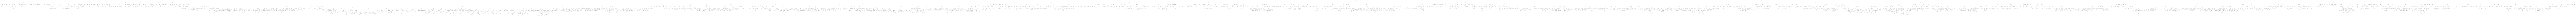

In [185]:
from subprocess import call 
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
from IPython.display import Image

Image(filename = 'tree.png')


In [184]:
graph

In [ ]:
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.metrics import r2_score

# max = 0
# max_depth = 0

# for i in range(1,15):
#   dtR = DecisionTreeRegressor(max_depth= i)
#   dtR = dtR.fit(X_train, y_train)
#   predict_price = dtR.predict(X_test)

#   # 測試集的結果評價
#   # print('迴歸樹準確率[max_depth: %d]:'%i,dtR.score(X_test, y_test))
#   if max < dtR.score(X_test, y_test):
#     max = dtR.score(X_test, y_test)
#     max_depth = i
# print('最大迴歸樹準確率，深度%d'%max_depth ,max)

#####經過PCA

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, new_y, test_size=0.3, random_state=1234)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train, y_train)

predictions = dtree.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.60      0.60      0.60      4687
           2       0.50      0.50      0.50      4782
           3       0.56      0.57      0.56      4780
           4       0.72      0.70      0.71      4806

    accuracy                           0.59     19055
   macro avg       0.59      0.59      0.59     19055
weighted avg       0.59      0.59      0.59     19055



In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

DecisionTree_model = DecisionTreeClassifier()
kf = KFold(n_splits=5, shuffle=True)
score_ndarray = cross_val_score(DecisionTree_model, X, new_y, cv=kf)
print(score_ndarray)
print(score_ndarray.mean())

[0.59907109 0.59529245 0.59663072 0.59639455 0.59426907]
0.5963315752184524


In [ ]:
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.metrics import r2_score

# max = 0
# max_depth = 0

# for i in range(1,15):
#   dtR = DecisionTreeRegressor(max_depth= i)
#   dtR = dtR.fit(X_train, y_train)
#   predict_price = dtR.predict(X_test)

#   # 測試集的結果評價
#   # print('迴歸樹準確率[max_depth: %d]:'%i,dtR.score(X_test, y_test))
#   if max < dtR.score(X_test, y_test):
#     max = dtR.score(X_test, y_test)
#     max_depth = i
# print('最大迴歸樹準確率，深度%d'%max_depth ,max)

####隨機森林

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(norm_X, new_y, test_size=0.3, random_state=1234)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

randomForest_model = RandomForestClassifier()
kf = KFold(n_splits=5, shuffle=True)
score_ndarray = cross_val_score(randomForest_model, X, new_y, cv=kf)
print(score_ndarray)
print(score_ndarray.mean())

[0.68466224 0.68293189 0.68362403 0.68113234 0.68733993]
0.6839380861009436


In [ ]:
randomForest_model = randomForest_model.fit(X_train, y_train)
predictions = randomForest_model.predict(X_test)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           1       0.66      0.77      0.71      5339
           2       0.61      0.53      0.57      5505
           3       0.66      0.62      0.64      5410
           4       0.78      0.80      0.79      5418

    accuracy                           0.68     21672
   macro avg       0.68      0.68      0.68     21672
weighted avg       0.68      0.68      0.68     21672



In [ ]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = randomForest_model.estimators_[4]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = X.columns, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

KeyboardInterrupt: ignored

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 
PATH = "tree.png"
Image(filename = PATH , width=1000, height=1000)

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score

# randomForest_model = RandomForestRegressor()
# kf = KFold(n_splits=5, shuffle=True)
# score_ndarray = cross_val_score(randomForest_model, X, new_y, cv=kf)
# print(score_ndarray)
# print(score_ndarray.mean())

####線性回歸

#####沒有PCA

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(norm_X, norm_y, test_size=0.3, random_state=1234)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn import metrics
import seaborn as sns

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
print(lr.intercept_)
print(lr.coef_)
print(f_regression(X_train, y_train)[1])

-1927988237.1463666
[ 4.58273764e-03  1.50372735e-02  6.90592802e-04 -2.42467906e-03
 -4.78148311e-04  1.83216125e-03 -2.72881531e-02 -6.18672243e-02
 -1.99094222e-02  5.60449844e-02  4.20097717e-03  5.60732092e-04
  2.16774573e-01  6.87088624e-02 -1.46487550e+08 -1.46487550e+08
 -1.46487550e+08 -1.46487550e+08  2.07447579e+09  2.07447579e+09
  2.07447579e+09  2.07447579e+09]
[1.11867541e-139 1.08766894e-067 6.25900184e-032 8.86765465e-059
 1.68058650e-049 0.00000000e+000 7.69827032e-265 1.62269503e-015
 1.29965417e-006 4.45802270e-085 9.51987240e-084 1.96736991e-127
 0.00000000e+000 0.00000000e+000 2.33278769e-087 1.22363779e-288
 0.00000000e+000 9.84244920e-302 2.74268323e-001 0.00000000e+000
 5.57491325e-115 1.08815338e-139]


In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared', lr.score(X_train, y_train))

MAE: 0.005982292040602593
MSE: 0.00011141801735615656
RMSE: 0.010555473336433405
R-squared 0.22386929287344648


In [ ]:
lr.score(X_train, y_train), 1 - (1-lr.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1) 

(0.22386929287344648, 0.22353147086575453)

#####有PCA

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, norm_y, test_size=0.3, random_state=1234)
#X_train_pca = pca.fit_transform(X_train)
#X_test_pca = pca.transform(X_test)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn import metrics
import seaborn as sns

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
print(lr.intercept_)
print(lr.coef_)
print(f_regression(X_train_pca, y_train)[1])

-0.6313997846883488
[ 3.67528495e-02  1.23263306e-06  5.39185917e-03  1.01988019e-02
 -1.12322159e-02 -1.96035209e-03 -1.67738196e-05 -1.44051555e-02
  2.94576781e-04  1.74499800e-02 -1.28594503e-02 -7.45869140e-03
  1.91860901e-03  5.62475446e-08 -1.46281030e-02 -3.80229226e-02
 -5.85187299e-02  1.11169756e-01 -6.31060888e-03 -1.44260711e-03
 -4.26589951e-03  1.20191155e-02]
[0.00000000e+000 4.86388334e-001 9.89669599e-170 0.00000000e+000
 0.00000000e+000 1.04296283e-147 6.65651792e-171 4.79022687e-112
 2.68600122e-055 1.44898545e-021 1.88806751e-095 3.93432994e-038
 7.27848664e-019 1.39561134e-013 4.45974945e-128 4.35602250e-229]


In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared', lr.score(X_train, y_train))

MAE: 0.10852974957391576
MSE: 0.0196211210465997
RMSE: 0.14007541199867912
R-squared 0.3413215240450378


####ANN(其他深度學習架構）

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, norm_y, test_size=0.3, random_state=1234)

In [ ]:
#建立ANN的多重感知分類器
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(X_train, y_train)

In [ ]:
#測試模組的準確率
mlp.score(X_test, y_test)

####多項式回歸

In [ ]:
from sklearn.preprocessing import PolynomialFeatures 

poly = PolynomialFeatures(degree = 3) 
X_poly = poly.fit_transform(X_train) 
predict_ = poly.transform(X_test)

lin2 = LinearRegression() 
lin2.fit(X_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures 

poly_ = PolynomialFeatures(degree = 4) 
X_poly_ = poly_.fit_transform(X_train) 
predict = poly_.transform(X_test)

lin3 = LinearRegression() 
lin3.fit(X_poly_, y_train)

In [ ]:
y_pred = lin3.predict(predict3)

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared', lin2.score(X_poly, y_train))

MAE: 0.012751140159408415
MSE: 0.5644139640318319
RMSE: 0.7512748924540417
R-squared 0.44519131752732244


In [ ]:
poly = PolynomialFeatures(degree=2)
X_ = poly.fit_transform(X_train)
predict_ = poly.transform(X_test)

clf = LinearRegression()
clf.fit(X_, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_pred = clf.predict(predict_)

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared', clf.score(X_, y_train))

MAE: 0.005654631296317861
MSE: 0.0008836843944148063
RMSE: 0.029726829538563412
R-squared 0.4397463500191786
